In [68]:
import sys
sys.path.append('../utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe, read_microns_per_pixel, calculate_one_micron, get_barcode_coordinates, read_image, crop_image, save_image_as_btf

# Load the DataFrame
df = load_dataframe('../data/raw/p5/binned_outputs/square_002um/spatial/tissue_positions.parquet')

# Read microns_per_pixel from JSON file
json_path = '/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/raw/p5/binned_outputs/square_002um/spatial/scalefactors_json.json'
microns_per_pixel = read_microns_per_pixel(json_path)
one_micron = calculate_one_micron(microns_per_pixel)



In [69]:
import geopandas as gpd
from shapely.geometry import Polygon
# Get barcode coordinates
#first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col = get_barcode_coordinates(df, one_micron)
geojson_file = '../data/processed/dataframe_ground_truth.geojson'

# Read GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(geojson_file)

geometry = gdf[gdf['path_class'] == 'roi_cropped']['geometry'].iloc[0]

# Access exterior coordinates of the polygon
coordinates = geometry.exterior.coords.xy

# Assign coordinates to variables
first_barcode_pxl_row = int(min((coordinates[1])))  # Y-coordinate of the first point
first_barcode_pxl_col = int(min(coordinates[0]))# X-coordinate of the first point
last_barcode_pxl_row = int(max(coordinates[1]))  # Y-coordinate of the last point
last_barcode_pxl_col = int(max(coordinates[0]))  # X-coordinate of the last point

print(first_barcode_pxl_row, first_barcode_pxl_col,last_barcode_pxl_row,last_barcode_pxl_col)


37928 30713 41044 33865


In [71]:
# Read the image
dir_base = '../data/raw/p5/'
filename = 'Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf'
img = read_image(dir_base + filename)

# Crop the image using the calculated coordinates
cropped_img = crop_image(img, first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col)

print(cropped_img.shape)

output_filename = 'p5_cropped_image.btf'
output_dir = '../data/processed'
output_path = os.path.join(output_dir, output_filename)
save_image_as_btf(cropped_img, output_path)

(3116, 3152, 3)
Cropped image saved as ../data/processed/p5_cropped_image.btf


In [81]:
import sys
sys.path.append('../utils')

# Importing importlib for module reloading
import importlib
import image_segmentation, geodataframe_creation

# Reloading the module
importlib.reload(image_segmentation)

from skimage.io import imread
from image_segmentation import segment_image
from geodataframe_creation import create_geodataframe

# Assuming you have loaded 'cropped_img' using imread or some other method
#cropped_img = read your btf from previous step

# Perform image segmentation
polys = segment_image(cropped_img)

# Create GeoDataFrame from segmented polygons
gdf = create_geodataframe(polys)
gdf.to_file('../data/processed/dataframe_stardist.geojson', driver='GeoJSON')

# Now 'gdf' contains the GeoDataFrame with polygons and IDs
print(gdf.head())


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(2000, 2000, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 4/4 [00:49<00:00, 12.44s/it]


                                            geometry    id
0  POLYGON ((1158.149 1638.000, 1157.883 1641.159...  ID_1
1  POLYGON ((1045.461 1002.000, 1045.140 1003.420...  ID_2
2  POLYGON ((702.701 1410.000, 702.168 1411.625, ...  ID_3
3  POLYGON ((1433.145 1498.000, 1432.733 1499.339...  ID_4
4  POLYGON ((1315.366 1802.000, 1314.835 1803.359...  ID_5


In [25]:
import geopandas as gpd
from shapely.geometry import Polygon

# Function to adjust polygon coordinates
def adjust_polygon(polygon, x_offset, y_offset):
    new_coords = [(x + x_offset, y + y_offset) for x, y in polygon.exterior.coords]
    return Polygon(new_coords)

# Adjusting the coordinates in the GeoDataFrame
gdf['geometry'] = gdf['geometry'].apply(lambda poly: adjust_polygon(poly, first_barcode_pxl_col, first_barcode_pxl_row))

# Display the updated geometries
print(gdf['geometry'])
gdf.to_file('../data/processed/dataframe_stardist_adjust.geojson', driver='GeoJSON')


0       POLYGON ((31871.149 39566.000, 31870.883 39569...
1       POLYGON ((31758.461 38930.000, 31758.140 38931...
2       POLYGON ((31415.701 39338.000, 31415.168 39339...
3       POLYGON ((32146.145 39426.000, 32145.733 39427...
4       POLYGON ((32028.366 39730.000, 32027.835 39731...
                              ...                        
7056    POLYGON ((32818.607 40556.000, 32818.841 40556...
7057    POLYGON ((32814.473 40168.000, 32813.933 40171...
7058    POLYGON ((33124.141 39984.000, 33124.051 39984...
7059    POLYGON ((32870.881 40086.000, 32866.039 40088...
7060    POLYGON ((33650.147 40296.000, 33650.566 40296...
Name: geometry, Length: 7061, dtype: geometry


In [99]:
import geopandas as gpd
from shapely.geometry import Polygon

gdf = gpd.read_file('../data/processed/dataframe_ground_truth.geojson')
gdf.crs = None
# Function to adjust polygon coordinates
def adjust_polygon(polygon, x_offset, y_offset):
    new_coords = [(float(x - x_offset), float(y - y_offset)) for x, y in polygon.exterior.coords]
    return Polygon(new_coords)

# Filter the GeoDataFrame where path_class is null
gdf_filtered = gdf[gdf['path_class'].isnull()].copy()

# Adjusting the coordinates in the filtered GeoDataFrame using .loc to avoid SettingWithCopyWarning
gdf_filtered.loc[:, 'geometry'] = gdf_filtered['geometry'].apply(lambda poly: adjust_polygon(poly, first_barcode_pxl_col, first_barcode_pxl_row))

# Save the updated GeoDataFrame back to a new GeoJSON file
gdf_filtered.to_file('../data/processed/updated_dataframe_ground_truth.geojson', driver='GeoJSON')

# Display the updated geometries
print(gdf_filtered['geometry'])



0       POLYGON ((2217.000 395.000, 2215.000 396.000, ...
1       POLYGON ((2145.000 394.000, 2143.000 395.000, ...
2       POLYGON ((1443.000 2629.000, 1442.000 2630.000...
3       POLYGON ((1457.000 2662.000, 1456.000 2663.000...
4       POLYGON ((1418.000 2652.000, 1417.000 2653.000...
                              ...                        
1575    POLYGON ((2145.000 192.000, 2144.000 193.000, ...
1576    POLYGON ((2082.000 196.000, 2081.000 197.000, ...
1577    POLYGON ((2155.000 207.000, 2154.000 208.000, ...
1578    POLYGON ((2239.000 320.000, 2237.000 321.000, ...
1579    POLYGON ((2230.000 357.000, 2229.000 358.000, ...
Name: geometry, Length: 1573, dtype: geometry


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


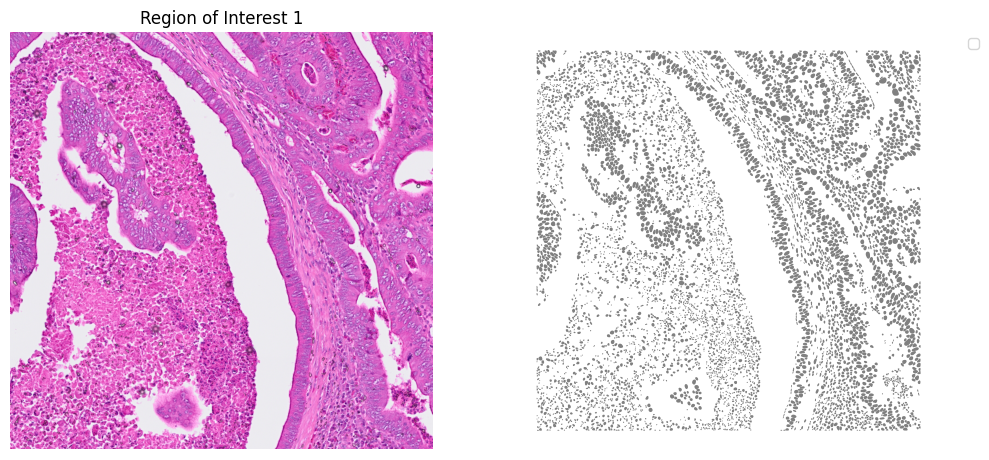

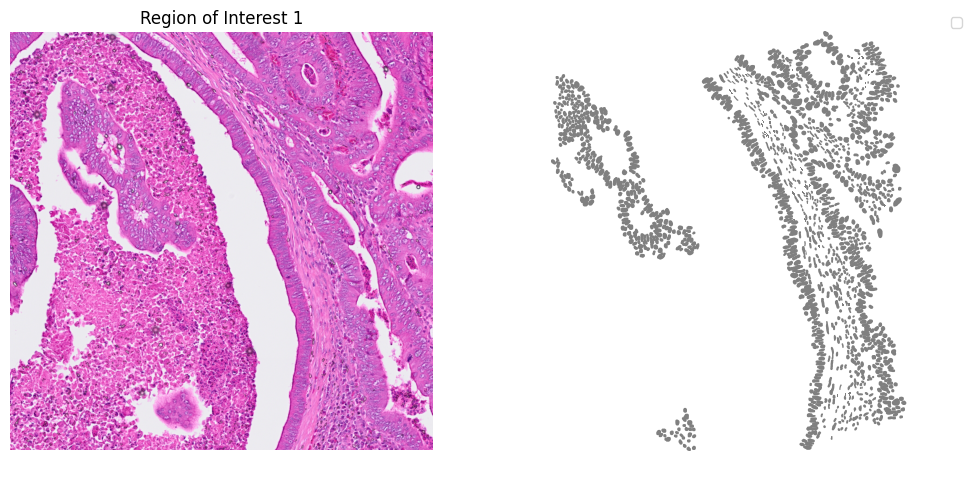

In [100]:
import importlib
import image_plot_utils

# Reloading the module
importlib.reload(image_plot_utils)

from skimage.io import imread
from image_plot_utils import plot_mask_and_save_image
gdf = gpd.read_file('../data/processed/dataframe_stardist.geojson')
gdf.crs = None
plot_mask_and_save_image(title="Region of Interest 1",
                         gdf=gdf,
                         cmap=cmap,
                         img=cropped_img,
                         output_name="../data/processed/p5_image_mask_stardist.ROI1.tif")


file_path = '../data/processed/updated_dataframe_ground_truth.geojson'
gdf3 = gpd.read_file(file_path)
gdf3.crs = gdf.crs

plot_mask_and_save_image(title="Region of Interest 1",
                         gdf=gdf3,
                         cmap=cmap,
                         img=cropped_img,
                         output_name="../data/processed/p5_image_mask_Chang.ROI1.tif")
